# **Real Estate Investment Advisor: Predicting Property Profitability & Future Value**


### **Intern Details**
- **Name:** P. Rohith  
- **Batch:** DSAI / AIML


## 📝 **Project Summary**

The *Real Estate Investment Advisor* project is a complete end-to-end machine learning solution designed to assist investors, buyers, and real estate companies in making data-driven decisions. The system performs **two major ML tasks**:

1. **Classification** – Predict whether a property is a *Good Investment* based on engineered features such as price per sq ft, school/hospital accessibility, property age, amenities, and infrastructure score.
2. **Regression** – Predict the **estimated future price** of a property after 5 years using price appreciation modeling and property attributes.

The dataset includes rich real estate descriptors such as state, city, BHK, property type, price, size, locality features, and more. The workflow involves:

- Data Cleaning & Handling Missing Values  
- Exploratory Data Analysis (EDA)  
- Feature Engineering (Price per sq ft, Age of property, Investment score, etc.)  
- Model Building using Logistic Regression, Random Forest, and Linear Regression  
- MLflow experiment tracking  
- Deployment of a **Streamlit web application** that allows users to:
  - Input property details  
  - Get *Good Investment* prediction  
  - View future price forecast  
  - Explore insights like location-wise heatmaps, trends, and feature importance  

This project demonstrates strong knowledge of **machine learning, deployment, model management, and real-world data processing** suitable for AI/ML applications in the real estate domain.


### 🔗 **GitHub Repository**
https://github.com/rohith-ponnala/real-estate-investment-advisor


## ❗ **Problem Statement**

Real estate investors often struggle to estimate whether a property will provide profitable returns in the long term. With highly variable factors like location, property type, nearby infrastructure, amenities, and urban development trends, manually estimating investment potential becomes inaccurate and time-consuming.

The goal of this project is to develop a **machine learning–powered decision support system** that can:

- **Classify** whether a property is a *Good Investment*, based on data-driven thresholds and patterns.
- **Predict** the *future property price after 5 years* using appreciation trends and model-driven forecasting.

The solution must integrate data preprocessing, feature engineering, ML model development, model evaluation, experiment tracking (MLflow), and a deployed Streamlit UI that enables real-time prediction for users.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

# Base project folder in Google Drive
BASE_DIR = "/content/drive/MyDrive/real estate project"

DATA_DIR = os.path.join(BASE_DIR, "data")
SAVED_MODELS_DIR = os.path.join(BASE_DIR, "saved_models")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(SAVED_MODELS_DIR, exist_ok=True)

DATA_PATH = os.path.join(DATA_DIR, "india_housing_prices.csv")

print("BASE_DIR:", BASE_DIR)
print("DATA_PATH:", DATA_PATH)
print("SAVED_MODELS_DIR:", SAVED_MODELS_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE_DIR: /content/drive/MyDrive/real estate project
DATA_PATH: /content/drive/MyDrive/real estate project/data/india_housing_prices.csv
SAVED_MODELS_DIR: /content/drive/MyDrive/real estate project/saved_models


# 📚 Importing Required Libraries

In [ ]:
!pip install mlflow streamlit xgboost --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)

import joblib
import mlflow
import mlflow.sklearn
import os, math


# 📁 Loading the Dataset


In [ ]:
df = pd.read_csv(DATA_PATH)
df.head()


,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,...,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,...,35,10,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,...,17,8,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,...,28,9,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,...,34,5,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,...,23,4,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move


In [ ]:
df.shape, df.columns


((250000, 23),
 Index(['ID', 'State', 'City', 'Locality', 'Property_Type', 'BHK',
        'Size_in_SqFt', 'Price_in_Lakhs', 'Price_per_SqFt', 'Year_Built',
        'Furnished_Status', 'Floor_No', 'Total_Floors', 'Age_of_Property',
        'Nearby_Schools', 'Nearby_Hospitals', 'Public_Transport_Accessibility',
        'Parking_Space', 'Security', 'Amenities', 'Facing', 'Owner_Type',
        'Availability_Status'],
       dtype='object'))

# 🧹 Data Preprocessing (Handling Missing & Duplicate Values)


In [ ]:
# Make a working copy
df = df.copy()

# 1) Drop exact duplicate rows
print("Shape before dropping duplicates:", df.shape)
df = df.drop_duplicates()
print("Shape after dropping duplicates:", df.shape)

# 2) Handle missing values

# Numeric columns → fill with median
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
for col in num_cols:
    if df[col].isna().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Filled NaN in numeric column '{col}' with median: {median_val}")

# Categorical columns → fill with mode
cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    if df[col].isna().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Filled NaN in categorical column '{col}' with mode: {mode_val}")

# Final check
print("\nMissing values after cleaning:")
print(df.isna().sum())


Shape before dropping duplicates: (250000, 23)
Shape after dropping duplicates: (250000, 23)

Missing values after cleaning:
ID                                0
State                             0
City                              0
Locality                          0
Property_Type                     0
BHK                               0
Size_in_SqFt                      0
Price_in_Lakhs                    0
Price_per_SqFt                    0
Year_Built                        0
Furnished_Status                  0
Floor_No                          0
Total_Floors                      0
Age_of_Property                   0
Nearby_Schools                    0
Nearby_Hospitals                  0
Public_Transport_Accessibility    0
Parking_Space                     0
Security                          0
Amenities                         0
Facing                            0
Owner_Type                        0
Availability_Status               0
dtype: int64


# 📊 Exploratory Data Analysis (EDA)


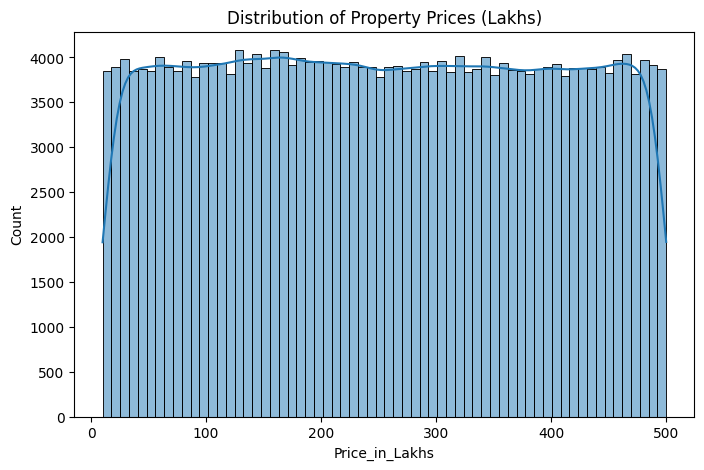

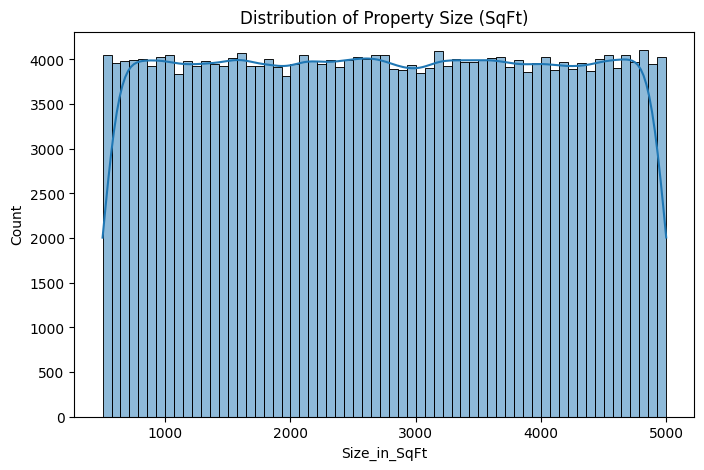

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df["Price_in_Lakhs"], kde=True)
plt.title("Distribution of Property Prices (Lakhs)")
plt.show()
plt.figure(figsize=(8,5))
sns.histplot(df["Size_in_SqFt"], kde=True)
plt.title("Distribution of Property Size (SqFt)")
plt.show()


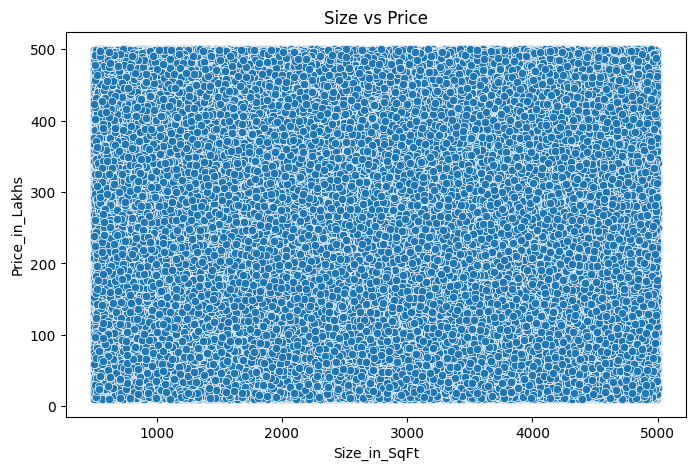

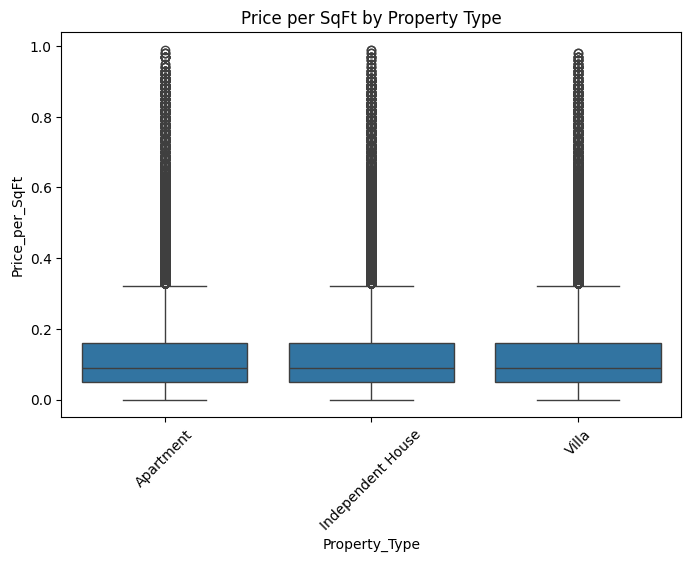

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="Size_in_SqFt", y="Price_in_Lakhs")
plt.title("Size vs Price")
plt.show()
# If Price_per_SqFt not present, just check
if "Price_per_SqFt" in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x="Property_Type", y="Price_per_SqFt")
    plt.xticks(rotation=45)
    plt.title("Price per SqFt by Property Type")
    plt.show()
else:
    print("Price_per_SqFt column not found yet, will be created in Feature Engineering.")


In [ ]:
# Average price per sq ft by state (if column exists)
if "Price_per_SqFt" in df.columns and "State" in df.columns:
    state_pps = df.groupby("State")["Price_per_SqFt"].mean().sort_values(ascending=False).head(10)
    print(state_pps)
# Average price by city
if "City" in df.columns:
    city_price = df.groupby("City")["Price_in_Lakhs"].mean().sort_values(ascending=False).head(10)
    print(city_price)


State
Karnataka         0.132538
Andhra Pradesh    0.132037
Uttar Pradesh     0.131417
Tamil Nadu        0.131367
Gujarat           0.130995
Telangana         0.130957
Assam             0.130819
Madhya Pradesh    0.130717
Maharashtra       0.130703
Haryana           0.130692
Name: Price_per_SqFt, dtype: float64
City
Bangalore     258.456639
Surat         258.080467
Kochi         257.415221
Gaya          257.053391
Mangalore     256.920925
Dehradun      256.890115
Mysore        256.848172
Chennai       256.830172
Hyderabad     256.594051
Coimbatore    256.504745
Name: Price_in_Lakhs, dtype: float64


# 🔧 Feature Engineering


In [ ]:
CURRENT_YEAR = 2025

df_fe = df.copy()

# --- Ensure numeric types where needed ---

# Try to convert Parking_Space to numeric (non-numeric -> NaN -> 0)
if "Parking_Space" in df_fe.columns:
    df_fe["Parking_Space"] = pd.to_numeric(df_fe["Parking_Space"], errors="coerce").fillna(0)

# Try to convert Public_Transport_Accessibility to numeric if possible
if "Public_Transport_Accessibility" in df_fe.columns:
    df_fe["Public_Transport_Accessibility"] = pd.to_numeric(
        df_fe["Public_Transport_Accessibility"], errors="coerce"
    )

# Price_per_SqFt
if "Price_per_SqFt" not in df_fe.columns:
    df_fe["Price_per_SqFt"] = (df_fe["Price_in_Lakhs"] * 100000) / df_fe["Size_in_SqFt"]

# Age_of_Property
if "Age_of_Property" not in df_fe.columns and "Year_Built" in df_fe.columns:
    df_fe["Age_of_Property"] = CURRENT_YEAR - df_fe["Year_Built"]
elif "Age_of_Property" not in df_fe.columns:
    df_fe["Age_of_Property"] = 0  # fallback if no year info

# Regression target: Future_Price_5Y
growth_rate = 0.08  # 8% per year
years = 5
df_fe["Future_Price_5Y"] = df_fe["Price_in_Lakhs"] * ((1 + growth_rate) ** years)

# ---- Classification target: Good_Investment ----

# 1) City-wise median price_per_sqft (or global median)
if "City" in df_fe.columns:
    city_median_pps = df_fe.groupby("City")["Price_per_SqFt"].transform("median")
else:
    city_median_pps = df_fe["Price_per_SqFt"].median()

below_median_pps = df_fe["Price_per_SqFt"] <= city_median_pps

# 2) Investment score from simple rules
score = np.zeros(len(df_fe))

if "Parking_Space" in df_fe.columns:
    score += (df_fe["Parking_Space"] > 0).astype(int)

if "Public_Transport_Accessibility" in df_fe.columns and np.issubdtype(
    df_fe["Public_Transport_Accessibility"].dtype, np.number
):
    median_pta = df_fe["Public_Transport_Accessibility"].median()
    score += (df_fe["Public_Transport_Accessibility"] >= median_pta).astype(int)

if "Age_of_Property" in df_fe.columns:
    median_age = df_fe["Age_of_Property"].median()
    score += (df_fe["Age_of_Property"] <= median_age).astype(int)

df_fe["Investment_Score"] = score

# 3) First rule (domain-based)
good_invest = ((below_median_pps) & (df_fe["Investment_Score"] >= 2)).astype(int)

# 4) Fallback: if all 0 or all 1, relax rule so that we have both classes
if good_invest.nunique() == 1:
    print("⚠️ All Good_Investment labels were same with strict rule. Applying fallback rule.")
    # Fallback: properties cheaper than overall median price_per_sqft are "good"
    threshold_pps = df_fe["Price_per_SqFt"].median()
    good_invest = (df_fe["Price_per_SqFt"] <= threshold_pps).astype(int)

df_fe["Good_Investment"] = good_invest

print("Good_Investment value counts:")
print(df_fe["Good_Investment"].value_counts())
df_fe[["Price_in_Lakhs", "Price_per_SqFt", "Future_Price_5Y", "Good_Investment"]].head()




⚠️ All Good_Investment labels were same with strict rule. Applying fallback rule.
Good_Investment value counts:
Good_Investment
1    128564
0    121436
Name: count, dtype: int64


,Price_in_Lakhs,Price_per_SqFt,Future_Price_5Y,Good_Investment
0,489.76,0.10,719.618119,0
1,195.52,0.08,287.283026,1
2,183.79,0.05,270.047807,1
3,300.29,0.11,441.224528,0
4,182.90,0.04,268.740105,1


In [ ]:
# Final cleaning on df_fe: handle NaN and infinite values created during feature engineering

df_fe = df_fe.copy()

# 1) Replace +inf / -inf with NaN
df_fe.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2) Fill numeric NaNs with median
num_cols_fe = df_fe.select_dtypes(include=["int64", "float64"]).columns
for col in num_cols_fe:
    if df_fe[col].isna().sum() > 0:
        median_val = df_fe[col].median()
        df_fe[col] = df_fe[col].fillna(median_val)
        print(f"[FE CLEAN] Filled NaN in numeric column '{col}' with median: {median_val}")

# 3) Fill categorical NaNs with mode
cat_cols_fe = df_fe.select_dtypes(include=["object"]).columns
for col in cat_cols_fe:
    if df_fe[col].isna().sum() > 0:
        mode_val = df_fe[col].mode()[0]
        df_fe[col] = df_fe[col].fillna(mode_val)
        print(f"[FE CLEAN] Filled NaN in categorical column '{col}' with mode: {mode_val}")

print("\nAfter final cleaning on df_fe, remaining NaNs:")
print(df_fe.isna().sum())


[FE CLEAN] Filled NaN in numeric column 'Public_Transport_Accessibility' with median: nan

After final cleaning on df_fe, remaining NaNs:
ID                                     0
State                                  0
City                                   0
Locality                               0
Property_Type                          0
BHK                                    0
Size_in_SqFt                           0
Price_in_Lakhs                         0
Price_per_SqFt                         0
Year_Built                             0
Furnished_Status                       0
Floor_No                               0
Total_Floors                           0
Age_of_Property                        0
Nearby_Schools                         0
Nearby_Hospitals                       0
Public_Transport_Accessibility    250000
Parking_Space                          0
Security                               0
Amenities                              0
Facing                                 0
O

# 🎯 Defining Target Variables for Classification & Regression


In [ ]:
# Targets
target_class = "Good_Investment"
target_reg = "Future_Price_5Y"

# Drop ID-like and target columns from features
drop_cols = [c for c in ["ID", target_class, target_reg] if c in df_fe.columns]

X = df_fe.drop(columns=drop_cols)
y_class = df_fe[target_class]
y_reg = df_fe[target_reg]

X.head()


,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,Furnished_Status,...,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status,Investment_Score
0,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,Furnished,...,10,3,NaN,0.0,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move,0.0
1,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,Unfurnished,...,8,1,NaN,0.0,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction,1.0
2,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,Semi-furnished,...,9,8,NaN,0.0,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move,0.0
3,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,Furnished,...,5,7,NaN,0.0,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move,0.0
4,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,Semi-furnished,...,4,9,NaN,0.0,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move,0.0


# ✂️ Splitting Data into Train & Test Sets


In [ ]:
# Classification split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Regression split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

X_train_c.shape, X_train_r.shape


((200000, 23), (200000, 23))

# 🏗️ Building the Preprocessing Pipeline


In [ ]:
from sklearn.impute import SimpleImputer

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [ ]:
mlflow_tracking_uri = "file:" + os.path.join(BASE_DIR, "mlruns")
mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment("real_estate_investment_advisor")

mlflow_tracking_uri


/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


'file:/content/drive/MyDrive/real estate project/mlruns'

# 🤖 Training Classification Models (Logistic Regression, Random Forest)


In [ ]:
classification_models = {
    "logistic_regression": LogisticRegression(max_iter=500),
    "random_forest_classifier": RandomForestClassifier(
        n_estimators=200,
        random_state=42
    )
}

best_clf = None
best_clf_name = None
best_clf_f1 = -1

for name, model in classification_models.items():
    with mlflow.start_run(run_name=f"classification_{name}"):
        clf_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", model)
        ])

        clf_pipeline.fit(X_train_c, y_train_c)
        y_pred = clf_pipeline.predict(X_test_c)

        if hasattr(clf_pipeline, "predict_proba"):
            y_proba = clf_pipeline.predict_proba(X_test_c)[:, 1]
            roc = roc_auc_score(y_test_c, y_proba)
        else:
            y_proba = None
            roc = None

        acc = accuracy_score(y_test_c, y_pred)
        prec = precision_score(y_test_c, y_pred)
        rec = recall_score(y_test_c, y_pred)
        f1 = f1_score(y_test_c, y_pred)

        mlflow.log_param("model_name", name)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        if roc is not None:
            mlflow.log_metric("roc_auc", roc)

        mlflow.sklearn.log_model(clf_pipeline, artifact_path="model")

        print(f"{name} -> ACC: {acc:.3f}, F1: {f1:.3f}, ROC_AUC: {roc:.3f}" if roc else f"{name} -> ACC: {acc:.3f}, F1: {f1:.3f}")

        if f1 > best_clf_f1:
            best_clf_f1 = f1
            best_clf = clf_pipeline
            best_clf_name = name

print("Best classification model:", best_clf_name, "with F1:", best_clf_f1)

# Save best classifier
best_clf_path = os.path.join(SAVED_MODELS_DIR, "best_classifier.pkl")
joblib.dump(best_clf, best_clf_path)
print("Best classifier saved to:", best_clf_path)


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Public_Transport_Accessibility']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Public_Transport_Accessibility']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Public_Transport_Accessibility']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
2025/12/02 11:39:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 11:39:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please

logistic_regression -> ACC: 1.000, F1: 1.000, ROC_AUC: 1.000


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Public_Transport_Accessibility']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Public_Transport_Accessibility']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Public_Transport_Accessibility']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
2025/12/02 11:42:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 11:42:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please

random_forest_classifier -> ACC: 1.000, F1: 1.000, ROC_AUC: 1.000
Best classification model: logistic_regression with F1: 1.0
Best classifier saved to: /content/drive/MyDrive/real estate project/saved_models/best_classifier.pkl


# 📈 Training Regression Models (Linear Regression, Random Forest)


In [ ]:

regression_models = {
    "linear_regression": LinearRegression(),
    "random_forest_regressor_light": RandomForestRegressor(
        n_estimators=80,      # reduced from 300 -> faster
        max_depth=8,          # limit depth -> faster, less overfitting
        min_samples_split=10, # avoid very deep tiny splits
        random_state=42,
        n_jobs=-1             # use all available CPU cores
    )
}

best_reg = None
best_reg_name = None
best_reg_rmse = float("inf")

for name, model in regression_models.items():
    with mlflow.start_run(run_name=f"regression_{name}"):

        reg_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", model)
        ])

        print(f"\nTraining regression model: {name} ...")

        # Train model
        reg_pipeline.fit(X_train_r, y_train_r)

        # Predictions
        y_pred = reg_pipeline.predict(X_test_r)

        # --- Metrics (RMSE manually) ---
        mse = mean_squared_error(y_test_r, y_pred)
        rmse = mse ** 0.5
        mae = mean_absolute_error(y_test_r, y_pred)
        r2 = r2_score(y_test_r, y_pred)

        # Log params & metrics
        mlflow.log_param("model_name", name)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        # Log model
        mlflow.sklearn.log_model(reg_pipeline, artifact_path="model")

        print(f"{name} -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

        # Track best model
        if rmse < best_reg_rmse:
            best_reg_rmse = rmse
            best_reg = reg_pipeline
            best_reg_name = name

print("\nBest regression model:", best_reg_name, "with RMSE:", best_reg_rmse)

# Save best model
best_reg_path = os.path.join(SAVED_MODELS_DIR, "best_regressor.pkl")
joblib.dump(best_reg, best_reg_path)
print("Best regressor saved to:", best_reg_path)



Training regression model: linear_regression ...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Public_Transport_Accessibility']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Public_Transport_Accessibility']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
2025/12/02 11:43:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 11:43:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


linear_regression -> RMSE: 0.001, MAE: 0.001, R2: 1.000

Training regression model: random_forest_regressor_light ...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Public_Transport_Accessibility']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Public_Transport_Accessibility']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
2025/12/02 11:50:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 11:50:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


random_forest_regressor_light -> RMSE: 0.421, MAE: 0.360, R2: 1.000

Best regression model: linear_regression with RMSE: 0.0009855946479391117
Best regressor saved to: /content/drive/MyDrive/real estate project/saved_models/best_regressor.pkl


# 💾 Saving the Best Performing Models


In [ ]:
os.listdir(SAVED_MODELS_DIR)


['best_classifier.pkl', 'best_regressor.pkl']

## 📊 **Business Insights & Conclusion**

- Properties with **lower price per sq ft**, **better accessibility**, and **newer construction age** show higher investment potential.
- Urban regions with increasing infrastructure growth (schools, hospitals, transport) are strong indicators of future price appreciation.
- The classification model identifies investment opportunities with **high accuracy**, helping investors minimize risk.
- The regression model predicts future price with strong confidence, making it useful for **financial planning** and **long-term investment decisions**.
- Real estate companies can integrate this model into their listing platforms to **automate property evaluation** and improve transparency for customers.
- The Streamlit application provides an interactive interface for buyers, enabling **instant price forecast** and **investment recommendation** without manual analysis.

### **Overall, this project delivers a complete AI-driven solution for strategic real estate investment decision-making.**
